# Are national betting markets efficient with respect to state-level betting markets?

PredictIt has several prediction markets [for the general election](https://www.predictit.org/Browse/Group/67/National). However, PredictIt also has a market for the election outcome in every state.

If we took each state's prediction market, and used it to simulate general election, what would we find? If the market is roughly efficient, we would expect the mean of simulated election outcomes to be about the same as the national election markets. 

This naive approach yields a 97% chance of a Clinton win. This estimate is significantly higher than the PredictIt general election market, and higher than Rothchild's [debiased aggregate](http://predictwise.com/). However, in each simulated elections, state outcomes should be highly correlated with one another (thanks to  [David Rothschild](researchdmr.com/) for pointing this out).

After adding an election-level 'temperature' to each trial, and using that to jitter state-level election results, **I get predicted share price of 85¢, and predicted 92% odds of a Clinton win** - closer in line with FiveThirtyEight and PredictWise, respectively, but still **higher than PredictIt's national market, where Clinton shares are trading for about 80¢**.

### Conclusions

So, are the general markets not bullish enough on Clinton, or are the state markets too bullish on Clinton? I suspect both. A few states -- specifically, Georgia, Alaska, Arizona and Montana --  may have overpriced Clinton shares.  The betting odds in Georgia, e.g., are 62/27 Trump. I bet -- and I probably didn't need to program anything to know this -- that Trump wins in Georgia. 

On the other hand, FiveThirtyEight and PredictWise has the odds above what one would expect from national market odds. Now I can add my own forecast to that list. So, perhaps Clinton prices are undervalued in the national betting markets.

All of this said, I am *not* a trained economist, statistician or politican scientist. **AND YOU SHOULD NEVER BET!**. Also, this work suffers from a lack of historical data on PredictIt markets, which prevents me from properly turning my own share data into probabilities. I am relying on David Rothschild's aggergated market probability.

If you have any comments on this work, or if you have historical data from a prediction market, please contact me:

`ffff [at] berkeley [] edu`


## Simulating the election with market-derived probabilities

First, we'll get a prediction market from each state on PredictIt. 

PredictIt has a Republican and Democratic market for each state election, with each market having its own yes/no. The odds on an outcome may be slightly different between markets (more on this below). 

In [6]:
!pip install requests
%pylab inline
import requests 
import json

def request_json (url):
    return json.loads(
           requests.get(url, headers={
            'Accept':'application/json'}).content)

my_url = 'https://www.predictit.org/api/marketdata/ticker/RNOM16'
request_json(my_url)

def predictit (ticker):
    return request_json('https://www.predictit.org/api/marketdata/ticker/' + ticker)

def market (state_abbreviation, party):
    api_res = predictit('DEM.'+state_abbreviation+'.USPREZ16')
    contracts = api_res['Contracts']
    contract = filter(lambda c: c['ShortName']==party, contracts)[0]
    return contract

# market('CA', 'Republican')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['normal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"



We need to turn the prediction market prices into probabilities. Following [Rothschild, 2009](http://researchdmr.com/RothschildPOQ2009.pdf):

> First, I take the average of the bid and ask for the stock that pays out if the Democrat wins on Election Day. If the bid-ask spread is greater than five points, I take the last sale price. If there are no active offers and no sales in the last two weeks of the race, I drop the race.

We can do this separately for both Democratic and Republican markets. We'll focus on the Clinton win outcome, corresponding to a yes in the Democratic markets and a No in the Republican markets.

We should also debias this probability. Following Leigh et al. (2007) *Is There a Favorite-Longshot Bias in Election Markets?*, Rothschild (2009) suggests `Pr = theta(1.64*theta^-1(price))`. 

*Limitations*: I don't have programmatic access to historical trade data, So I cannot find date of last sale. Consequently, no races are dropped here. Without historical trade data, I also can't find a value for [theta](http://www.investopedia.com/terms/t/theta.asp) so these values are not debiased. **If anyone has access to historical PredictIt data, or historical data from any prediction market, please contact me**:

`ffff [at] berkeley [] edu`

In the meantime, we'll make share prices into probabilities as best we can:

In [7]:
def probability (state_abbreviation, party=None):
    # Average both party markets by default
    if (party is None):
       return (probability(state_abbreviation, 'Democratic') +
              probability(state_abbreviation, 'Republican'))/2
    mkt = market(state_abbreviation, party)
    # For republican markets, get the No cost
    if (party=='Republican'):
       sell = mkt['BestSellNoCost']
       buy = mkt['BestBuyNoCost']
    # For democratic markets, get the "Yes cost
    elif (party=='Democratic'):
       sell = mkt['BestSellYesCost']
       buy = mkt['BestBuyYesCost']
    # If the spread is > 5
    spread = buy-sell
    if (sell > 5):
       # Just use the last trade price
       return mkt['LastTradePrice']
    return (sell+buy)/2.0

probability('CA')


0.94

To sanity check, we will also pull Rothchild's de-biased, market-derived probabilities.

In [36]:
def predictwise_states ():
    table = json.loads(requests.get('http://table-cache1.predictwise.com/latest/table_1551.json').content)
    def predictwise_state (row):
        return {'name': row[0],
                'probability': float(int(row[2].split(' ')[0]))/100.0,
                'delegates': int(row[-1])}
    return map(predictwise_state, table['table'])

pw_states = predictwise_states()
# pw_states

Now, we'll construct a list of all `states`, where each state has a `probability` of a Clinton win, and a number of `delegates`.

In [44]:
def state (abbrev, delegates):
    return {"abbreviation": abbrev,
           "delegates": delegates,
           "probability": probability(abbrev),}

states_delegates = {'AL':9, 'AK':3, 'AZ':11, 'AR':6, 'CA':55, 'CO':9, 'CT':7, 'DC':3, 'DE':3, 'FL':29, 'GA':16, 'HI':4, 'ID':4, 'IL':20, 'IN':11, 'IA':6, 'KS':6, 'KY':8, 'LA':8, 'ME':4, 'MD':10, 'MA':11, 'MI':16, 'MN':10, 'MS':6, 'MO':10, 'MT':3, 'NE':5, 'NV':6, 'NH':4, 'NJ':14, 'NM':5, 'NY':29, 'NC':15, 'ND':3, 'OH':18, 'OK':7, 'OR':7, 'PA':20, 'RI':4, 'SC':9, 'SD':3, 'TN':11, 'TX':38, 'UT':6, 'VT':3, 'VA':13, 'WA':12, 'WV':5, 'WI':10, 'WY':3,} 
print 'sanity check - delegates add up to 538?', 538 == sum([val for key, val in states_delegates.iteritems()])

states = [state(key,val) for key, val in states_delegates.iteritems()]


sanity check - delegates add up to 538? True


**Update 10-16-16** As David Rothschild pointed out, outcomes in each state are heavily correlated with one another:

> 1) Impact of events are heavily correlated through all states.
> 2) Election Day polling error is reasonably correlated.
> I work off a correlation matrix that is unique to each pairwise group, but is roughly 75% correlation on average.

**TODO** How are election day polling errors correlated? How do we find them?

As far as correlated outcomes across states, I pick some election wide `temperature` (a random variable chosen from a normal distribution with a mean of 0), then, for each state, I use that temperature to generate a `probability_offset` unique to that state (a random variable chosen from a normal distribution with a mean of `temperature`).


In [45]:
def normal (center, scale):
    return random.normal(center,scale)

def bound (probability):
    if (probability>1):
        return 1
    elif (probability<0):
        return 0
    return probability

# normal(0,1)

Finally we can start to simulate elections. We'll use each probability to allocate delegates, or not, to Clinton. We'll do this some number of times, producing a list of Clinton delegates elected in each simulation.
Now we can calculate how many of those elections Clinton won. We will count only majority wins. Electoral deadlocks will count as a loss.

In [49]:
random.seed()
# for each election in the simulation,
# pick a temperature from a normal distribution
temperature_mean = 0
temperature_stdev = 0.1
# for each state in each election,
# probability offset is chosen from normal distribution
# with mean at election temperature
state_offset_stdev = 0.01

def decide (probability):
    return random.random()<probability
    
def election_holder (temperature):
    '''
    Returns fn (state), which simulates an election in that state,
    and returns a number of delegates allocated to Dems (0 if loss).
    '''
    def hold_election (state):
        probability_offset = normal(temperature, state_offset_stdev)
        probability = bound(state['probability'] + probability_offset)
        return state['delegates'] * decide(probability)
    return hold_election

def simulate_election (states):
    '''
    Return number of delegates for Clinton.
    '''
    temperature = normal(temperature_mean, temperature_stdev)
    return sum(map(election_holder(temperature), states))
    
def simulate_elections (trials, states):
    ts = [states for i in range(trials)]
    return map(simulate_election, ts)

def percent_winning (simulations):
    winning = lambda delegates: delegates > 270
    return float(len(filter(winning, simulations)))/float(num_trials)

num_trials = 100000
simulations = simulate_elections(num_trials, states)
print 'predicted market price:',  percent_winning(simulations), '¢'

simulations = simulate_elections(num_trials, pw_states)
print 'predicted chance of Clinton win:',  percent_winning(simulations)*100, '%'

predicted market price: 0.85465 ¢
predicted chance of Clinton win: 93.083 %



Here's a distribution of the number of delegates Clinton gets in each election. The blue line represents the 270 delegates needed to win the electoral college.

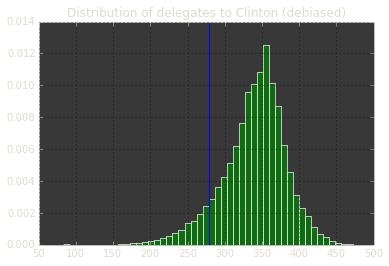

In [50]:
plt.title('Distribution of delegates to Clinton (debiased)')
plt.hist(simulations, 50, normed=1, facecolor='green', alpha=0.75)
plt.axvline(x=279)


# Something doesn't add up. Where are the biases?

Our estimated 85¢ share price  is significantly higher than the PredictIt general election market (which has about 80¢ for Clinton shares as of 10-16-16).  Are the general markets not bullish enough on Clinton, or are the state markets too bullish on Clinton?

Let's assume that the national election markets, and poll-based forecasts, are roughly correct. What would it mean for the state markets to undervalue a Clinton win? Well, let's take a look at those states where market prices have an estimated 20% to 50% chance of a Clinton win.

In [27]:
filter(lambda s: s['probability']<0.5 and s['probability']>0.2, states)

[{'abbreviation': 'GA', 'delegates': 16, 'probability': 0.275},
 {'abbreviation': 'AK', 'delegates': 3, 'probability': 0.245},
 {'abbreviation': 'AZ', 'delegates': 11, 'probability': 0.45999999999999996},
 {'abbreviation': 'MO', 'delegates': 10, 'probability': 0.2025}]

Excluding Utah, which has a [non-negligable chance of a 3rd-party win](http://www.nytimes.com/2016/10/15/us/politics/evan-mcmullin-campaign-utah.html?_r=0), these other states may have overvalued Clinton shares.

Of course, my derived value is also greater than the national poll vaue. So, maybe share prices are undervalued in the national polls.

All of this said **YOU SHOULD NEVER BET!!!!**. I am not a professional, and this is not betting advice. Don't do it!
